# Indice

[Introdução](#Introdução)

[Desenvolvimento](#Desenvolvimento)

[Resultados](#Resultados)

[Conclusões](#Conclusões)


# Introdução


A transmissao de sinal é o processo de enviar e propagar um sinal analógico ou digital atraves de cabo, fibra óptica, *wireless* ou outro meio de transmissão. Um exemplo de transmissão é uma chamada telefónica ou o envio de um e-mail. Tipicamente a transmissão de informação é realizada de forma digital e veio substituir a transmissão de sinais analógicos, isto porque um sinal analógico não pode ser limpo e sofre degradação em longas distancias, um repetidor analógico pode amplificar o sinal mas irá também amplificar o seu ruído. Os sinais digitais podem ser reconstruídos com menor ruído e regenerado para o seu estado original. Estas são algumas das razões principais da transmissão de sinais digitais em grandes distâncias por parte das empresas de telecomunicacões.

A conversão de analógico para digital é realizada em tres etapas: A **amostragem** que tem como objectivo tornar o sinal discreto no dominio do tempo e não envolve perda de informação respeitando o teorema de *Nyquist* cuja frequência do sinal amostrado tem de ser duas vezes superior á do sinal original; A **quantização** que torna as amostras do sinal discretas na amplitude, transformando uma variável continua num número finito de valores; A **codificação** que atribui a cada amplitude de pulso um codigo binário.

O **controlo de erros** tem como objectivo a detecção e correcção de erros, devido a estarmos perante um sinal digital este processo dá-se ao nível dos codigos binários do sinal. Existem dois tipos de erros de bit: os erros devido aos efeitos do canal de natureza aleatória; e os erros devido a interferências electromagnéticas em rajada.
Dependendo do tipo de erros existem estratégias diferenciadas para, no receptor, os detectar ou mesmo corrigir. Para que seja possivel realizar este processo é necessario introduzir bits com informação relativa ao controlo de erros.

A **modelação digital** é o processo no qual a informação transmitida numa comunicação é adicionada ao sinal electromagnético. O transmissor adiciona a informação numa onda especial de tal forma que poderá ser recuparada no receptor através de um processo reverso chamado desmodulação.

O **canal** é meramente o meio utilizado para transmitir o sinal do transmissor ao receptor. Pode ser um par de condutores, um cabo coaxial, uma banda de frequências de rádio, um feixe de luz, etc.

![Envio e recepcao de informação](https://preview.ibb.co/eKoeuw/Screenshot_from_2018_01_02_19_00_46.png)

# Desenvolvimento

A transmissão de sinal é dividida em vários blocos, a quantização, codificação, o controlo de erros, a modulação digital e o envio pelo canal. No receptor dá-se o mesmo processo de forma invertida em cada bloco. Assim foi construida uma biblioteca para isolar o código de cada bloco em diferentes ficheiros.

A **quantificação** de um sinal é o processo que converte um sinal amostrado, num sinal com valores tambem discretos em amplitude. Para quantificar um sinal aproxima-se cada valor através de um método que atribui os valores de quantificação `vj`, para tal usam-se valores de decisão `tj` equidistantes que serve de fronteira entre valores de quantificação.


```python
def uniform_midrise_quantizer(vmax, delta_q):
    vj = np.arange(-1 * vmax + delta_q / 2, vmax, delta_q)
    tj = np.arange(-1 * vmax + delta_q, vmax, delta_q)

    return vj, tj
```

```python
def quantize(signal, vmax, vj, tj):
    tj = np.insert(tj, len(tj), vmax)

    # majorate mq array as default value
    mq = np.ones(len(signal)) * np.max(vj)

    # majorate the index as default value
    idx = np.ones(len(signal), dtype='uint32') * len(vj)

    # loop every point in the signal and check if the point is lower or equal
    # than any tj elements (decision values)
    for i in range(len(signal)):
        eval = signal[i] <= tj

        # test whether any array element along a given axis evaluates to True
        if np.any(eval):
            xq_value = vj[eval][0]
            mq[i] = xq_value

            # get the index
            k = np.nonzero(eval)[0][0]
            idx[i] = k

    return mq, idx
```

```python
def dequantize(vj, indexes):
    return vj[indexes]
```


> **Exercício resolvido 3 da sebenta (parte 1, pag. 86)**

In [1]:
import numpy as np
from lib import quantization

# quantificar sinais ate 1v
vmax = 1

# 8 intervalos de quantificacao
l = 8

# intervalo de quantificacao
delta_q = 2 * vmax / l

vj, tj = quantization.uniform_midrise_quantizer(vmax, delta_q)

print('Valores de quantificacao:\n{}\n'.format(vj))
print('Valores de decisao:\n{}\n'.format(tj))

n = np.arange(0, 8)
m = np.sin(2 * np.pi * 1300 / 8000 * n)
r = 3

x1, idx = quantization.quantize(m, vmax, vj, tj)

print('Quantizacao:\n{}\n'.format(x1))

print('Dequantizacao:\n{}\n'.format(quantization.dequantize(vj, idx)))

Valores de quantificacao:
[-0.875 -0.625 -0.375 -0.125  0.125  0.375  0.625  0.875]

Valores de decisao:
[-0.75 -0.5  -0.25  0.    0.25  0.5   0.75]

Quantizacao:
[-0.125  0.875  0.875  0.125 -0.875 -0.875 -0.125  0.875]

Dequantizacao:
[-0.125  0.875  0.875  0.125 -0.875 -0.875 -0.125  0.875]



A **codificação** é a representacao binária da sequência de valores de um sinal, onde cada valor é exprimido atraves de um código binário. A esta codificação chama-se de modulação por código de pulso (PCM - *Pulse Code Modulation*). Os indices óbtidos no bloco de quantização são convertidos para o seu respectivo valor binário com uma representação a `r` bits.

O número de bits representados na codificação de cada número é variavel em cada problema, então assumiu-se que o tamanho máximo desta representação pode ter um máximo de 32 bits. Para optimizar esta conversão foi utilizada a função [`unpackbits()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unpackbits.html) do numpy que converte números inteiros de 8 bits. Assim foi criado um novo tipo de dados que inclui 4 parcelas de números a 8 bits, perfazendo os 32 bits definidos.

```python
def pcm_encode(idx: np.ndarray, r: np.int) -> np.ndarray:
    # new data type to divide an int32 variable into 4 int8 variables
    dt = np.dtype((np.int32, {'f0': (np.uint8, 3), 'f1': (np.uint8, 2), 'f2': (np.uint8, 1), 'f3': (np.uint8, 0)}))

    # convert the vector into new data type
    idx_uint8 = idx.view(dtype=dt)

    # pack an numpy array with the 4 uint8 variables
    idx_uint8 = np.array([idx_uint8['f0'], idx_uint8['f1'], idx_uint8['f2'], idx_uint8['f3']])

    # transpose so we get each number by row
    idx_uint8 = np.transpose(idx_uint8)

    # convert to binary
    idx_bin = np.unpackbits(idx_uint8, axis=1)

    # slice into the desired number of bits
    idx_bin = idx_bin[:, len(idx_bin[0]) - r:len(idx_bin[0])]

    return idx_bin
```

```python
def pcm_decode(bits: np.ndarray) -> np.ndarray:
    return bits.dot(1 << np.arange(len(bits[0]) - 1, -1, -1))
```

In [2]:
from lib import codification

x2 = codification.pcm_encode(idx, r)

print('Indices de quantizacao:\n{}\n'.format(idx))
print('Codificacao:\n{}\n'.format(x2))
print('A sequencia binaria a ser transmitida corresponde a concatenacao ' \
      'por ordem temporal dos codigos em binario:\n{}\n'.format(np.ndarray.flatten(x2)))
print('Descodificacao de bits:\n{}\n'.format(codification.pcm_decode(x2)))

Indices de quantizacao:
[3 7 7 4 0 0 3 7]

Codificacao:
[[0 1 1]
 [1 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]]

A sequencia binaria a ser transmitida corresponde a concatenacao por ordem temporal dos codigos em binario:
[0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1]

Descodificacao de bits:
[3 7 7 4 0 0 3 7]



O **controlo de erros** através do código de Hamming consegue corrigir 1 bit ou detectar 2 bits errados na mensagem. Este processo implica a adicão de bits de paridade á mensagem para serem utilizados na correcção.

A correcção é realizada pelo cálculo do síndroma da mensagem que corresponde ao indice da matrix `H` e ao índice da mensagem a ser corrigido.

```python
def hamming(x: np.ndarray, P: np.ndarray, n: np.int, r: np.int) -> np.ndarray:
    G = np.hstack((np.identity(r, dtype='uint8'), P))

    return np.dot(x, G) % 2
```

```python
def correction(y: np.ndarray, P: np.ndarray) -> np.ndarray:
    # form the H matrix
    H = np.vstack((P, np.identity(len(P[0]))))

    # calculate the S matrix
    S = np.dot(y, H) % 2

    # if S is == 0 then there's no error in that sub-message
    # else find the row position where sub-message is equal to S
    # then flip the bit in the sub-message at row position
    for row in range(len(S)):
        if np.all(S[row] == 0):
            continue

        col = np.argwhere(np.all(H == S[row], axis=1))[0][0]
        y[row, col] = np.logical_not(y[row, col])

    return y[:, 0:-1 * len(P[0])]
```

> **Exercício resolvido em aula**

In [3]:
from lib import error_control

# mensagem
m = np.array([[0, 1, 1, 1], [0, 0, 1, 0]])

# matriz paridade
p = np.array([[0, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 1]])

n = 7
k = 4

x4 = error_control.hamming(m, p, n, k)

print('Mensagem sem bits de paridade:\n{}\n'.format(np.ndarray.flatten(m)))
print('Mensagem com bits de paridade:\n{}\n'.format(np.ndarray.flatten(x4)))

x4[0][4] = np.logical_not(x4[0][4])

print('Messagem com bits de paridade e erro:\n{}\n'.format(np.ndarray.flatten(x4)))
print('Mensagem sem bits de paridade e corrigida:\n{}\n'.format(np.ndarray.flatten(error_control.correction(x4, p))))

Mensagem sem bits de paridade:
[0 1 1 1 0 0 1 0]

Mensagem com bits de paridade:
[0 1 1 1 1 0 0 0 0 1 0 1 0 1]

Messagem com bits de paridade e erro:
[0 1 1 1 0 0 0 0 0 1 0 1 0 1]

Mensagem sem bits de paridade e corrigida:
[0 1 1 1 0 0 1 0]



A maioria dos sinais, da forma como são fornecidos pelo transmissor, não podem ser enviados directamente atraves dos canais de transmissão. Consequentemente é necessario modificar esse sinal atraves de uma onda electromagnética portadora, cujas propriedades são mais convenientes aos meios de transmissão - **modulação digital**. O QAM é o processo de variação de amplitude de uma sinusoide que é criada atraves de uma constelacao onde cada quadrante foi codificado num conjunto de 4 bits (16-QAM) para cada simbolo, onde cada simbolo é constituido por `p` pontos que representam a sinusoide.

In [4]:
from lab04 import lab04

lab04.constellation_configuration()

Para construir cada simbolo substitui-se cada parcela de 4 bits pelas respectivas coordenadas da constelação aplicando a expressão:

![](https://latex.codecogs.com/gif.latex?simbolo%20%3D%20%5Ctheta_1%20%5Ccdot%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20cos%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29%20&plus;%20%5Ctheta_2%20%5Ccdot%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20sin%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29)

Após o sinal ser enviado pelo canal é necessario reverter o valor de cada simbolo para a coordenada da constelação e de seguida para a respectiva parcela de bits:

![](https://latex.codecogs.com/gif.latex?c_%7B1%7D%20%3D%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20cos%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29)
![](https://latex.codecogs.com/gif.latex?c_%7B2%7D%20%3D%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20sin%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29)
![](https://latex.codecogs.com/gif.latex?x%20%3D%20%5Csum%20simbolo%20%5Ccdot%20c_%7B1%7D)
![](https://latex.codecogs.com/gif.latex?y%20%3D%20%5Csum%20simbolo%20%5Ccdot%20c_%7B2%7D)

Para evitar um excesso de verificações de condições nos quadradantes calcularam-se duas formulas matemáticas para determinar o par de coordenadas `(x, y)`. Para tal identificou-se o padrão na configuração binária da constelação: Os dois bits á esquerda representam o sinal de x e y respectivamente, onde o bit 0 corresponde a um sinal positivo e o bit 1 ao negativo; Os dois bits á direita representam a coordenada absoluta de y e x respectivamente, onde o bit 0 corresponde ao valor de coordenada 1 e o bit 1 corresponde ao valor de coordenada 3.

![](http://image.ibb.co/miGxXG/Untitled_Diagram.png)

Fazendo uma regressão com estes valores obtém-se as seguintes expressões:

![](https://latex.codecogs.com/gif.latex?sinal%20%3D%20-2%20%5Ccdot%20bit%20&plus;%201)
![](https://latex.codecogs.com/gif.latex?coordenada%20%3D%202%20%5Ccdot%20bit%20&plus;%201)

```python
def qam_encode(x: np.ndarray, p: np.int) -> (np.ndarray, np.ndarray, np.int):
    coords, new_bits = constellation_encode(x)
    n = np.reshape(np.arange(p), (1, p))
    symbols = np.zeros((len(coords), np.int(len(coords[0]) / 2 * p)), dtype=np.float32)

    for i in range(0, len(coords[0]), 2):
        col_x = np.reshape(coords[:, i + 0], (len(coords), 1))
        col_y = np.reshape(coords[:, i + 1], (len(coords), 1))

        j = np.int(p / 2 * i)
        symbols[:, j:j + p] = col_x * np.sqrt(2 / p) * np.cos(2 * np.pi * n * 1 / p) +\
                              col_y * np.sqrt(2 / p) * np.sin(2 * np.pi * n * 1 / p)

    return symbols, coords, new_bits
    
def constellation_encode(x: np.ndarray) -> (np.ndarray, np.int):
    # the constellation uses 4 bits and converts them to coordinates
    # the received matrix may not have a column length multiple of 4
    # so we need to add them now and remove them in the decode function
    multiple = len(x[0]) % 4
    new_bits = 0

    if multiple != 0:
        new_bits = 4 - multiple
        x = np.concatenate((x, np.zeros((len(x), new_bits), dtype=np.int8)), axis=1)

    coords = np.zeros((len(x), np.int(len(x[0]) / 2)), dtype=np.int8)

    # based on the constellation codification calculate the signal and
    # the (x, y) coordinate
    def signal_calc(s):
        return -2 * s + 1

    def coord_calc(c):
        return 2 * c + 1

    for i in range(0, len(coords[0]), 2):
        # calc all signals of x and y
        signal = signal_calc(x[:, i * 2:i * 2 + 2])

        # calc all values of coord x and y
        coord = coord_calc(x[:, i * 2 + 2:i * 2 + 4])

        coords[:, i:i + 2] = np.transpose(np.array([signal[:, 0] * coord[:, 1], signal[:, 1] * coord[:, 0]]))

    return coords, new_bits
```

```python
def qam_decode(y: np.ndarray, p: np.int, rm_bits: np.int) -> (np.ndarray, np.ndarray):
    n = np.reshape(np.arange(p), (1, p))
    c1 = np.sqrt(2 / p) * np.cos(2 * np.pi * n * 1 / p)
    c2 = np.sqrt(2 / p) * np.sin(2 * np.pi * n * 1 / p)
    coords_r = np.zeros((len(y), np.int(len(y[0]) * 2 / p)))
    coords_p = np.zeros((len(y), np.int(len(y[0]) * 2 / p)))

    def cell_round(c):
        return 2 * np.ceil(c / 2) - 1

    for i in range(0, len(coords_r[0]), 2):
        j = np.int(p / 2 * i)
        symbols = y[:, j:j + p]

        phi_x = np.sum(symbols * c1, axis=1)
        phi_y = np.sum(symbols * c2, axis=1)

        coords_p[:, i + 0] = phi_x
        coords_p[:, i + 1] = phi_y
        coords_r[:, i + 0] = cell_round(phi_x)
        coords_r[:, i + 1] = cell_round(phi_y)

    coords_r = np.clip(coords_r, -3, 3)

    return constellation_decode(coords_r, rm_bits), coords_r, coords_p
    
def constellation_decode(y: np.ndarray, rm_bits: np.int) -> np.ndarray:
    bits = np.zeros((len(y), np.int(len(y[0]) * 2)), dtype=np.int8)

    for i in range(0, len(y[0]), 2):
        signal_x = (y[:, i + 0] < 0) * 1
        signal_y = (y[:, i + 1] < 0) * 1

        bit_x = np.array((np.abs(y[:, i + 0]) - 1) / 2, dtype=np.uint8)
        bit_y = np.array((np.abs(y[:, i + 1]) - 1) / 2, dtype=np.uint8)

        j = i * 2
        bits[:, j:j + 4] = np.transpose(np.array([signal_x, signal_y, bit_y, bit_x]))

    if rm_bits != 0:
        return bits[:, 0:-1 * rm_bits]

    return bits
```

A transmissão de sinal é realizada atraves de o meio fisico, neste problema estamos perante uma simulação de transmissão de sinal e os efeitos do **canal** também devem de ser simulados. Assim é atribuido ruido do tipo AWGN ao sinal.

```python
def send_with_awgn(x: np.ndarray, sigma: np.float) -> np.ndarray:
    vector = matrix_to_vector(x)

    # Generate error/noise to simulate channel communication
    y = vector + sigma * np.random.randn(len(vector))

    return vector_to_matrix(y, len(x[0]))
```

# Resultados

A simulacao é constituida por:
* Condificador PCM com quantificador uniforme midrise com parametros: R = 8 (numero de bits de codificacao);
* Controlo de erros: Codigo de Hamming(15, 11);
* Modulação digital 16-QAM: p = 8 (numero de amostras para cada simbolo);
* Canal AWGN com parâmetros: sigma = [0.05, 0.1, 0.15, 0.2]

O sinal utilizado trata-se da musica introductoria do jogo super mario. Para obter uma análise mais pormenorizada foram criados varias versões deste ficheiro com diferentes durações.

Para analisar a transmissão do sinal seram calculadas as seguintes métricas para avaliar a sua qualidade:
* SNR (Signal to Noise Ratio) corresponde á relacao entre a potência do sinal original e a potência do sinal recebido. Quanto maior este valor menor é o efeito do ruido;

* BER (Bit Error Rate) corresponde á taxa de erro de um bit transmitido.

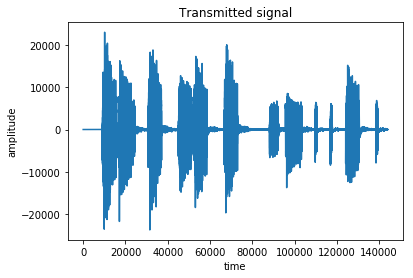

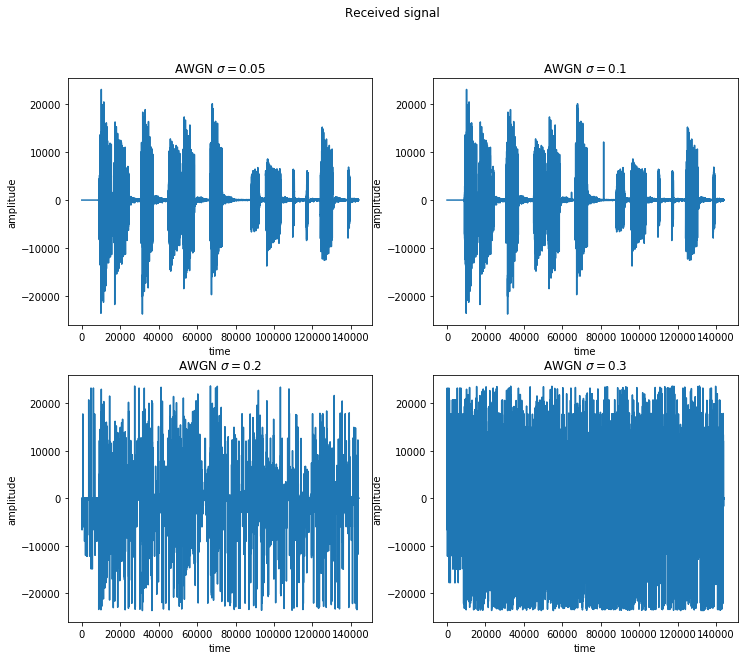

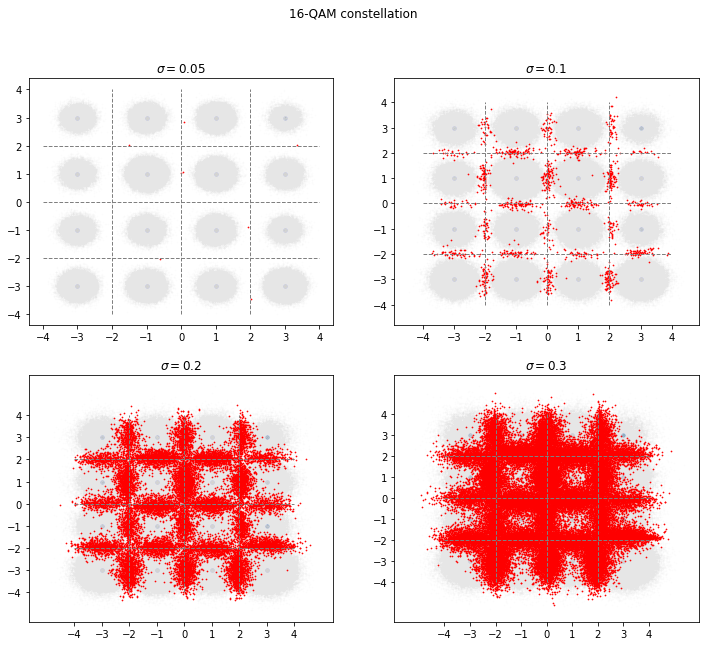

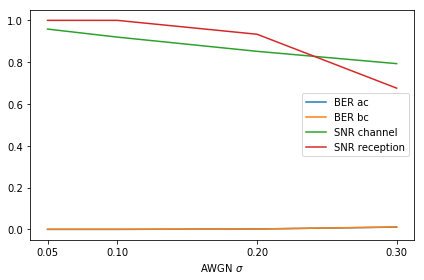

In [5]:
lab04.exercise()

Conforme o aumento do valor de sigma correspondente ao ruido AWGN verifica-se uma distorção no sinal recebido em relação ao sinal transmitido. Os graficos da constelação 16-QAM identificam a vermelho os pontos que foram mal classificados na recepção, isto é, o seu quadradante original é diferente do quandrante posterior.

Para finalizar oberserva-se uma relação entre os valores de SNR e BER. O aumento de sigma traduz-se na quantidade de ruido presente no canal, diminuindo o valor de SNR no canal e aumentando muito ligeiramente o valor de BER e com isto dá-se uma dimunuição na qualidade do sinal. É de frisar que a partir do valor sigma = 0.2 o SNR de recepção comeca a diminuir para valores inferiores ao SNR no canal, o que indica que o módulo de controlo de erros acaba por introduzir novos erros no algoritmo de correcção de erros. 

# Conclusões

A transmissão de sinais está presente em inúmeras tecnologias do dia-a-dia e com os conceitos estudados é possível projectar e analisar a qualidade das transmissões. Foi dado a conhecer o processo de transferência de informação entre um emissor e um receptor, mais particularmente como os bits de dados são transformados de maneira a que possam ser transmitidos por um meio fisico.

No ambito do desenvolvimento dos projectos seria uma mais valia tornar a simulação virtual da transmissão e recepção de sinal num meio fisico. Esta alteração poderia ajudar na compreensão dos conceitos envolvidos.

Devido ás limitações computacionais da linguagem Python e da grande quantidade de dados processados o código produzido foi optimizado o melhor possível através do uso das funcionalidades da biblioteca numpy. Com isto, a mudanca para uma linguagem com uma melhor performance computacional seria favorável.